# Support Vector Machine for classification algorithm

In the following project will be analyzed the dataset *airline.csv*; we'll also implement a ML algorithm for a classification problem. We'll try, in fact, by using SVC(support vector classifier) to classify the level of satisfaction of the customers of an airline. The variable of interest is binomial (satisfied, neutral or dissatisfied).

This dataset has been chosen because it contains **nominal**, **ordinal** e **quantitative** variables, allowing us to use different kind of statistical tests for evaluating the statistical significance with respect to the variable ```satisfaction```.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.contingency_tables as st
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.svm import SVC

%matplotlib inline

In [2]:
df = pd.read_csv('airline.csv').drop(['id', 'SR'], axis=1)

df.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## Handling missing values

In [3]:
print("Pct null values per column:\n", (df.isnull().sum() / df.shape[0]) * 100)

Pct null values per column:
 Gender                               0.000000
Customer_Type                        0.000000
Age                                  0.000000
Type_of_Travel                       0.000000
Class                                0.000000
Flight_Distance                      0.000000
Inflight_wifi_service                0.000000
Departure/Arrival_time_convenient    0.000000
Ease_of_Online_booking               0.000000
Gate_location                        0.000000
Food_and_drink                       0.000000
Online_boarding                      0.000000
Seat_comfort                         0.000000
Inflight_entertainment               0.000000
On-board_service                     0.000000
Leg_room_service                     0.000000
Baggage_handling                     0.000000
Checkin_service                      0.000000
Inflight_service                     0.000000
Cleanliness                          0.000000
Departure_Delay_in_Minutes           0.000000
Arriv

The column ```Arrival_Delay_in_Minutes``` is the only one with missing values. Those represent the **0.29 %** of the total. Given the extremely low percentage, we'll remove those rows from the dataset for it won't cause a substantial loss of information.

In [4]:
df = df.dropna()

In [5]:
print("Pct null values per column:\n", (df.isnull().sum() / df.shape[0]) * 100)

Pct null values per column:
 Gender                               0.0
Customer_Type                        0.0
Age                                  0.0
Type_of_Travel                       0.0
Class                                0.0
Flight_Distance                      0.0
Inflight_wifi_service                0.0
Departure/Arrival_time_convenient    0.0
Ease_of_Online_booking               0.0
Gate_location                        0.0
Food_and_drink                       0.0
Online_boarding                      0.0
Seat_comfort                         0.0
Inflight_entertainment               0.0
On-board_service                     0.0
Leg_room_service                     0.0
Baggage_handling                     0.0
Checkin_service                      0.0
Inflight_service                     0.0
Cleanliness                          0.0
Departure_Delay_in_Minutes           0.0
Arrival_Delay_in_Minutes             0.0
satisfaction                         0.0
dtype: float64


## Exploratory analysis


In this section we'll approach an exploratory analysis of the variables to have a clearer picture of the data we have. Among the classical central tendency and resuming statistics, we'll analize those variables which are of a quantitative type just to check for the presence of outliers.

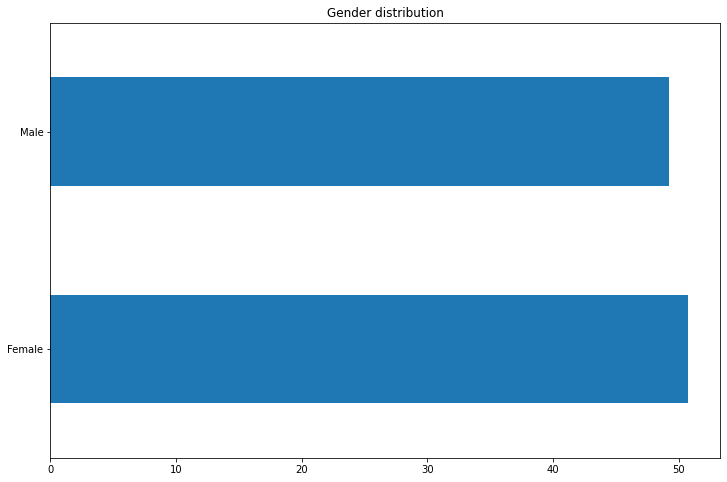

In [6]:
(df['Gender'].value_counts(normalize=True) * 100).plot(kind='barh', figsize=(12,8))
plt.title('Gender distribution')
plt.show()

For what concern the genre distribution, the dataset is extremely balanced with a small majority (little more than **50 %**) of female individuals.

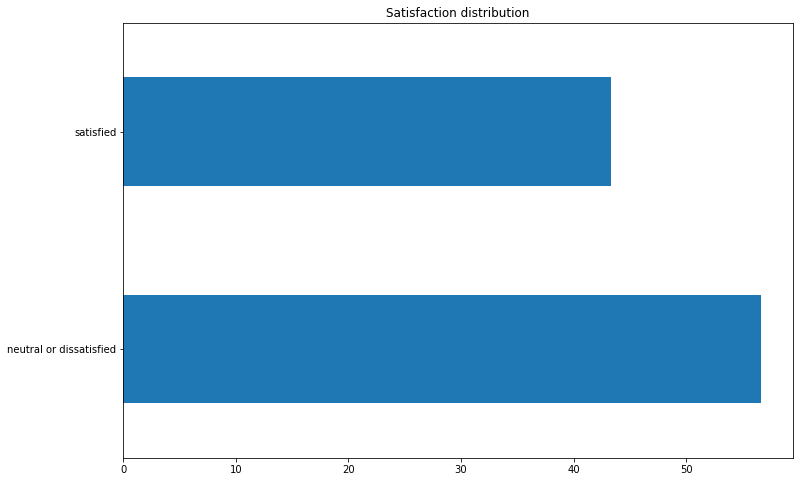

In [7]:
(df['satisfaction'].value_counts(normalize=True) * 100).plot(kind='barh', figsize=(12,8))
plt.title('Satisfaction distribution')
plt.show()

```satisfaction``` is our variable of interest (the target variable we'll try to classify to predict the outcome); in this bar plot we can see that the majority of customers is not satisfied. The percentage of satisfied is around **45 %**.


At this point we're interested in analyzing if there's any significant variation of the level of satisfaction given the gender.

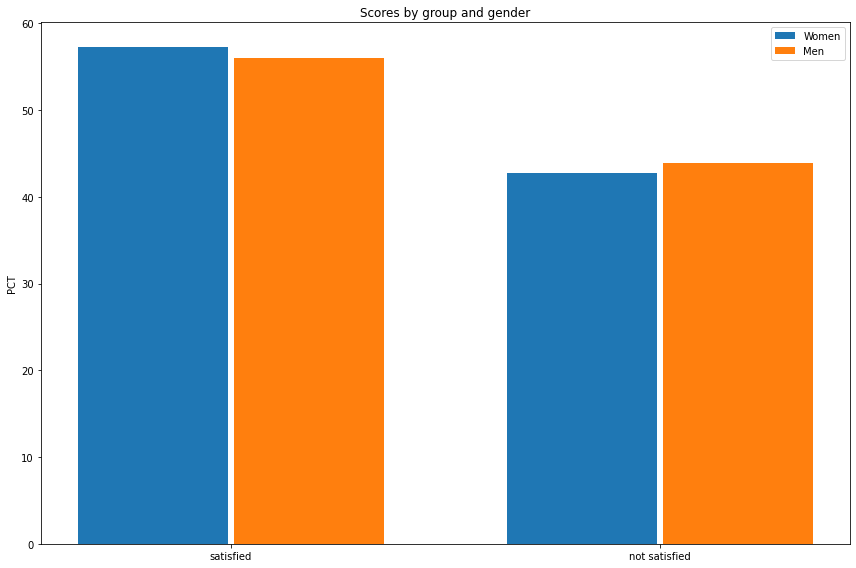

In [8]:
women_sat = round(df[df['Gender'] == 'Female']['satisfaction'].value_counts(normalize=True) * 100, 2)
men_sat = round(df[df['Gender'] == 'Male']['satisfaction'].value_counts(normalize=True) * 100, 2)

labels = ['satisfied', 'not satisfied']
x = np.arange(len(labels))
width = .35
fig, ax = plt.subplots(figsize=(12,8))

rects1 = ax.bar(x - width/2 - 0.007, women_sat, width, label='Women')
rects2 = ax.bar(x + width/2 + 0.007, men_sat, width, label='Men')

ax.set_ylabel('PCT', rotation=90)
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

We cannot see any significant variation among the genders. To us it seems that there is not a significative relation among the two variables (noth nominal).
We'll investigate further when we'll do a statistical analysis for the variables for modelling the ML algorithm.

## Outliers analysis

In this dataset there are some variables (```Flight_distance```, ```Departure_Delay_in_Minutes```, ```Arrival_Delay_in_Minutes```, ```Age```) that represent quantitative and continous data. Given these charateristics we can study the behaviours and manage the presence of outliers.

### Flight Distance, Departure Delay and Arrival Delay

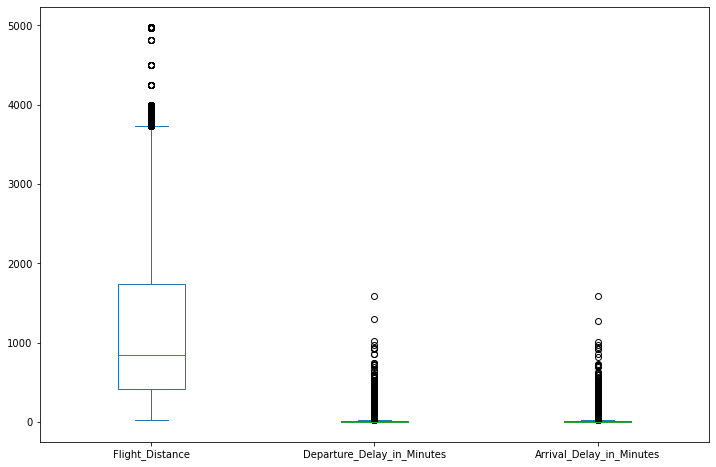

In [9]:
cols = ['Flight_Distance', 'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes']

df[cols].plot(kind='box', figsize=(12, 8))
plt.show()

It looks like the three variables contain some outliers. We have to considerate that, given the fact that those values extremely far from the central tendency indicators (and they are really far indeed), those same values are all likely and in fact highly probable. It is not rare, instead it is pretty usual, that many flights fly on routes of thousands of kilometers and it is also quite common that a flight has hours of delay from the scheduled departure. 
We could say that for flights that have more than **10** hours of delay, we could be in front of some outliers that could jeopardize our model.

In [10]:
dep_benchmark = 600
arr_benchmark = 600

outliers = df[(df['Departure_Delay_in_Minutes'] > dep_benchmark) & (df['Arrival_Delay_in_Minutes'] > arr_benchmark)]

outliers.shape[0] / df.shape[0] * 100

0.01641021680792324

There are **17** observations that are extreme outliers. Those represent the **0.016 %** of the full dataset; not a great loss of information by eliminating them.

In [11]:
df = df.drop(outliers.index, axis=0).copy()

If we see the boxplot of the flight distance, we can see how we're in presence of extremely low values. It seems to us extremely unlikely in fact that someone decides to take a flight for distances smaller than **100 km**. We'll se the proportion of this particular subset and, if the loss of information is negligible, we'll drop those rows.

In [12]:
small_distance_rows = df[(df['Flight_Distance'] > 0) & (df['Flight_Distance'] <= 100)]

small_distance_rows.shape[0] / df.shape[0] * 100

0.7984398080654973

This subset represents almost the **0.80 %** of the full dataset.

In [13]:
df = df.drop(small_distance_rows.index, axis=0).copy()

In [14]:
df.shape

(102750, 23)

### Age

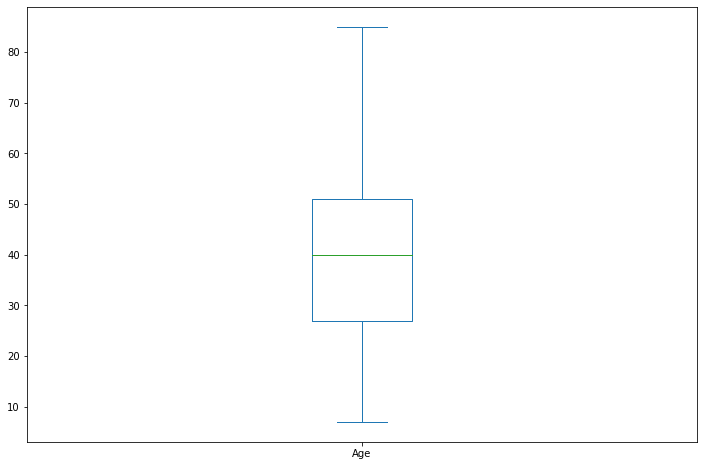

In [15]:
df['Age'].plot(kind='box', figsize=(12,8))
plt.show()

In the column  ```age``` we're not facing some particular and problematic value (e.g. negative values or values bigger than 100) however it seems highly uncommon that very young customers can fill a survey about the level of satisfaction for a service.
We'll deeply analyze a subset for the age up to 15 years old.

In [16]:
df[df['Age'] < 15]['Type_of_Travel'].value_counts()


Personal Travel    4022
Business travel    1139
Name: Type_of_Travel, dtype: int64

In the subset we can even see that some observations are stored as **Business travel**. Highly unlikely that in that age can do that type of travel; at this point we can consider those observations as misleading and caused, probably, by errors during the recordings. We'll drop them


In [17]:
final_df = df.drop(df[df['Age'] < 15].index, axis=0)

In [18]:
final_df.shape

(97589, 23)

## One-Hot encoding

We completed the first exploratory phase of our dataset where we solved some issues about missing values and about observations that we found to be quite unreliable.

We know that some columns store nominal values (```Gender```, ```Customer_Type```, ```Type_of_Travel```, ```Class```); to be able to use them we'll have to substitute with *dummy variables*, but before doing so we'll need to see if there's any statistical significancy among each of those variables and the dependent variable ```satisfaction```. To do so, we'll use the **chi-square test** so that we'll able to consider only those columns which p-value is less than **0.05**

We'll incapsulate the procedure inside of a function to make everything more flexible.

In [19]:
def chi_square_test(dataset, alpha):

    nominal_columns = dataset.select_dtypes(exclude=['number']).iloc[:,:-1].columns
    encoded = pd.get_dummies(final_df, columns=nominal_columns)
    dummy_col = encoded.columns[-9:-1]

    cols_to_drop = list()
    for c in dummy_col:
        tab = st.Table(pd.crosstab(encoded[c], encoded['satisfaction']))
        p_value = st.Table.test_nominal_association(tab).pvalue
        if p_value > alpha:
            cols_to_drop.append(c)
    
    if len(cols_to_drop) != 0:
        encoded.drop(cols_to_drop, axis=1, inplace=True)
        print(f"{cols_to_drop} dropped from dataset")
    else:
        print('All the variables are statistically significant.')
    
    return encoded

In [20]:
encoded_df = chi_square_test(final_df, alpha=0.05)

encoded_df.head()

All the variables are statistically significant.


,Age,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,...,satisfaction,Gender_Female,Gender_Male,Customer_Type_Loyal Customer,Customer_Type_disloyal Customer,Type_of_Travel_Business travel,Type_of_Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
1,25,235,3,2,3,3,1,3,1,1,...,neutral or dissatisfied,0,1,0,1,1,0,1,0,0
2,26,1142,2,2,2,2,5,5,5,5,...,satisfied,1,0,1,0,1,0,1,0,0
3,25,562,2,5,5,5,2,2,2,2,...,neutral or dissatisfied,1,0,1,0,1,0,1,0,0
4,61,214,3,3,3,3,4,5,5,3,...,satisfied,0,1,1,0,1,0,1,0,0
5,26,1180,3,4,2,1,1,2,1,1,...,neutral or dissatisfied,1,0,1,0,0,1,0,1,0


We worked with **nominal** type variables. We know that in the dataset there are some **ordinal** type columns; columns that measure the quality of some airport's and flight's services by using a range of values from **0** to **5**. Specifically:

* ```Inflight_wifi_service```
* ```Departure/Arrival_time_convenient```
* ```Ease_of_Online_booking```
* ```Gate_location```
* ```Food_and_drink```
* ```Online_boarding```
* ```Seat_comfort```
* ```Inflight_entertainment```
* ```On-board_service```
* ```Leg_room_service```
* ```Baggage_handling```
* ```Checkin_service```
* ```Inflight_service```
* ```Cleanliness```

Being **ordinal** variables, we'll have to use the **Cochrane-Armitage** to measure the level of statistical significancy with ```satisfaction```.
This test represents something similar to a "modified" chi-square test to be used with variables containing *k* categories and a binomial variable.

In [21]:
def cochrane_armitage(dataset, alpha):

    # Cochrane-Armitage test for significance (modified chi square test for both categorical and ordinal variables)

    ordinal_cols = dataset.loc[:, (dataset.nunique() > 2) & (dataset.nunique() <=6)].columns
    cols_to_drop = list()

    for c in ordinal_cols:
        tab = st.Table(pd.crosstab(dataset[c], dataset['satisfaction']))
        p_value = st.Table.test_ordinal_association(tab).pvalue

        if p_value > alpha:
            cols_to_drop.append(c)
            print(f"{c} is not statistically significant with satisfaction for a {p_value} p-value\nunder the assumption of null hypothesis")
    
    if len(cols_to_drop) != 0:
        dataset.drop(cols_to_drop, axis=1, inplace=True)
        print(f"{cols_to_drop} dropped from dataset")
    else:
        print("All the variables are statistically significant")
    
    return dataset

In [22]:
encoded_df = cochrane_armitage(encoded_df, alpha=0.05)

Gate_location is not statistically significant with satisfaction for a 0.9576038866324897 p-value
under the assumption of null hypothesis
['Gate_location'] dropped from dataset


## Machine Learning modelling

After having handled all the missing values, spotted those values that we can consider as outliers and done a first *feature selection*, we can start to train our first ML model by using the **Support Vector Classifier**.

This particular algorithm is, on a computational level, extremely complex for the machine, especially with a huge amount o observations and given our need to use some cross validation techniques for hyperparameters tuning; to solve this problem, we'll use a subset of **3000** observations (50 % coming from satisfied customers and the other 50 % from not satisfied) and we'll *standardize* numerical variables.

In [23]:
n_obs = 1500

satisfied = encoded_df[encoded_df['satisfaction'] == 'satisfied'].sample(n_obs, random_state=42)
not_satisfied = encoded_df[encoded_df['satisfaction'] == 'neutral or dissatisfied'].sample(n_obs, random_state=42)

df = pd.concat([satisfied, not_satisfied]).sample(frac=1, random_state=42).reset_index(drop=True)

# standardize values
# avoiding standardization of dummy variables because mean and standard deviation 
# of those particular values are not representative of anything for it is not a "real" distribution we have

df.iloc[:,:17] = (df.iloc[:,:17] - df.iloc[:,:17].mean()) / df.iloc[:,:17].std()

We can now proceed to train our first model. In this initial moment we'll use the default parameters coming from the scikit learn library.

In [24]:
X = df.drop('satisfaction', axis=1)
y = df['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

model = SVC()
model.fit(X_train, y_train)
preds = model.predict(X_test)

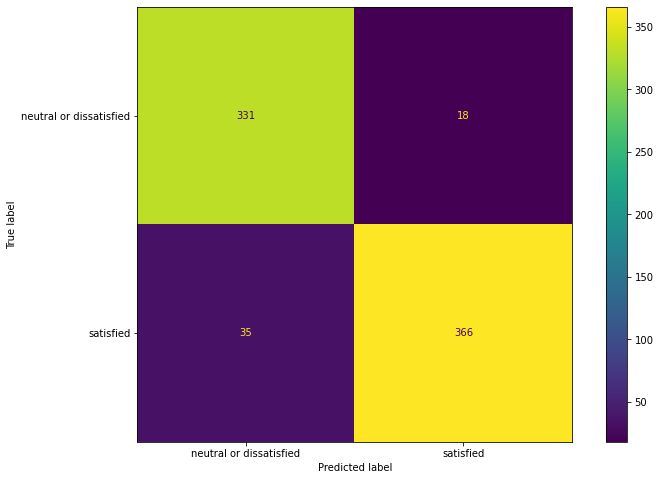

In [25]:
cfm = ConfusionMatrixDisplay(confusion_matrix(y_test, preds),display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(12, 8))
cfm.plot(ax=ax)
plt.show()

In [26]:
print(f"Accuracy score for the model: {accuracy_score(y_test, preds)}")

Accuracy score for the model: 0.9293333333333333


### Hyperparameters tuning

This first model behaves quite good with a **93 %** of accuracy score. From the confusion matrix we can observe that over a total of **401** satisfied customers, our model misclassified as not satisfied 35 (**8.73 %**) and over a total of 349 not satisfied customers, it misclassified as satisfied 18 (**5.16 %**).
As an overall score we weren't able to classify **7.07 %** of the observations.

We'll try now to tune the hyperparameters to see if these metrics can be effectively improved. We'll keep on use a non linear kernel *radial basis function*.
We'll start by using a randomized method which choose randomly among a range of different values. This method, differently from **GridSearchCV** allows a faster elaboration.
Once we found the best parameters, we'll do a new fitting by using the classic method with cross validation.

In [27]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'kernel': ['rbf'],
          'gamma': ['scale', 'auto'],
        }

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

gs = RandomizedSearchCV(model, 
                        param_distributions=params, 
                        scoring='accuracy', 
                        cv=cv,
                        n_jobs=-1)
gs.fit(X_train, y_train)

print(gs.best_estimator_)
print(gs.best_score_)
print(gs.best_params_)

SVC(C=10)
0.9199999999999999
{'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


In [28]:
params = {
          'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
        }
optimal_model = GridSearchCV(model, 
                             param_grid=params, 
                             cv=cv,
                             scoring='accuracy',
                             n_jobs=-1)
optimal_model.fit(X_train, y_train)
print(optimal_model.best_params_)


{'C': 100, 'gamma': 0.01}


In [29]:
print(f"Best accuracy score after 10 fold cross validation: {optimal_model.best_score_}")

Best accuracy score after 10 fold cross validation: 0.9226666666666666


At this point we'll initialize a new model with the best parameters we fetched.

In [30]:
new_model = SVC(C=100, kernel='rbf', gamma=0.01)
new_model.fit(X_train, y_train)
y_predict = new_model.predict(X_test)

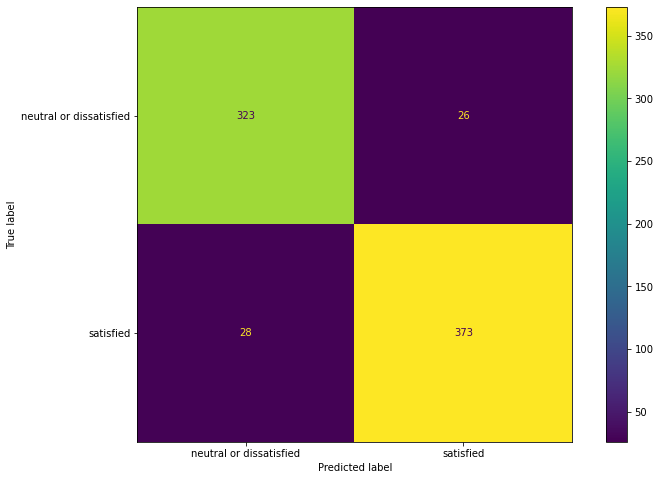

In [31]:
cfm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predict),display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(12, 8))
cfm.plot(ax=ax)
plt.show()

In [32]:
print(f"Accuracy score for the model: {accuracy_score(y_test, y_predict)}")

Accuracy score for the model: 0.928


With this new setting we succeded to improve the number of false negatives (satisfied customers whom the machine classified as not satisfied).

### Feature selection

One of the main problems when we modelize a ML algorithm is the so called *overfitting*; this happens when the model shows good performances on the train set but can't achieve the same level, in terms of error's metrics, on the test set. It depends on an extensive *learning process* over the train set (including statistical noise and variability caused by the sampling). Noise and variability are, indeed, approached as if they were almost structural parameters that, however, we won't find or we'll find different on the test set.

The more the dataset is complex (a.k.a great number of variables), the more the risk of overfitting increases. In our case, we're facing **26** explicative columns.
We'll see now how the algorithm performs if we vary the number of variables taken in consideration for the fitting.

In [33]:
train_scores = list()
test_scores = list()

for i in range(len(X_train.columns), 0, -1):

    X_train_reduced = X_train.iloc[:,:i]
    X_test_reduced = X_test.iloc[:,:i]

    new_model.fit(X_train_reduced, y_train)

    train_scores.append(new_model.score(X_train_reduced, y_train))
    test_scores.append(new_model.score(X_test_reduced, y_test))


In the block code above we iterated over the number of variables, by reducing its dimension of one unit and doing a new training of the model with the new *reduced* dataset.. After that we calculated the accuracy score of the new model for both the train set and the test set to study the variations with respect to the variation of the dimension.

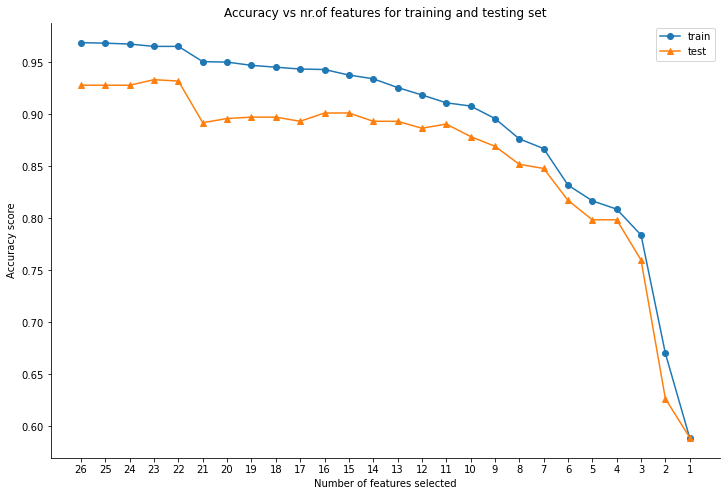

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("Accuracy vs nr.of features for training and testing set")
ax.plot(train_scores, marker='o', label='train')
ax.plot(test_scores, marker='^', label='test')
ax.set_xticks(range(len(test_scores)))
x_labels = range(26, 0, -1)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Number of features selected')
ax.set_ylabel('Accuracy score')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.legend()
plt.show()

In the graph above we observe that the model performes very well on the train set with the highest dimension of the dataset, however it is not able to obtain the maximum value of accuracy on the test set (typical case of overfitting). The test set shows better performances if the variables of the dataset are downed to **23**.

In [35]:
new_model.fit(X_train.iloc[:,:23], y_train)
accuracy_score(y_test, new_model.predict(X_test.iloc[:,:23]))

0.9333333333333333

In [36]:
y_pred = new_model.predict(X_test.iloc[:,:23])

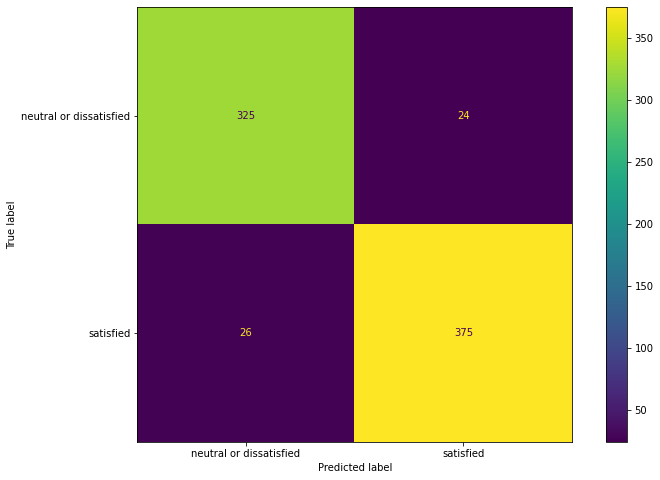

In [37]:
cfm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(12, 8))
cfm.plot(ax=ax)
plt.show()

By reducing the dimension of the dataset to **23** variables, we're able to improve the accuracy of **0.005 %**; this consequentially meant a clear upgrade of the criterions of classification of the algorithm. Only **6.48 %** of the satisfied customers were misclassified as not satisfied while the **6.88 %** of the not satisfied customers were classified as satisfied. In total, of the **750** observations of the test set, **6.70%** was misclassified.

## Conclusions

In this project we modelized a ML algorithm (SVC) for classifying the level of satisfaction of a sample of customers. After a first explorative analysis, we've been able to train a model that showed a level of accuracy of **93.3 %** by reducing the number of significative features.
If we want to resume we have:

* Deleted the null values for they were representing an extremely small percentage of the dataset (**0.29 %**)
* Handled a strategy for the outliers that we consider to be logical
* Extrapolated all the statistically significant variables by *HP testing*
* Optimized the parameters of the model with *cross-validation*
* Optimized the number of columns to use for the training and optaining a slight improvement of the classification's performances.